# Demo of Spectrum and SpectralLibrary

To run this demo, first download the complete ECOSTRESS spectral library data from the [ECOSTRESS website](https://speclib.jpl.nasa.gov/download) and unpack into a folder named `ECOSTRESS` in the current working directory.

If `tqdm` is installed, you'll get progress widgets that are nice to have.

In [13]:
from collections import Counter
import os
import re

from hyperspectral.spectra import Spectrum, SpectralLibrary
import matplotlib.pyplot as plt
import parsec

%matplotlib inline

In [2]:
_,_,files = next(os.walk('ECOSTRESS'))
files = list(map(lambda s: 'ECOSTRESS/' + s, filter(lambda s: s.endswith('.spectrum.txt'), files)))

try:
    from multiprocessing import Pool
    from tqdm.notebook import tqdm
    with Pool() as p:
        ecostress_raw = list(tqdm(p.imap(Spectrum.parse_ECOSTRESS, files), total=len(files)))
except:
    ecostress_raw = map(Spectrum.parse_ECOSTRESS, files)

ecostress = list(filter(lambda s: s['Wavelength Range'] != 'TIR', ecostress_raw))

set(map(lambda s: s['Wavelength Range'], ecostress))

{'All', 'VSWIR'}

### Resampling

In [3]:
floating = parsec.regex('[-+]?([0-9]+(\.[0-9]+)?|\.[0-9]+)')

@parsec.generate
def sample_row():
    λ = yield floating
    yield parsec.regex('\s+')
    fwhm = yield floating
    return (λ, fwhm)

spc_parser = parsec.sepBy(sample_row, parsec.many1(parsec.regex('\s')))

with open('data/aviris_wavelength_fwhm.dat', 'r') as f:
    raw_spc = f.read()

aviris_sample_points = list(map(lambda x: float(x[0])/1000, spc_parser.parse(raw_spc)))
aviris_range = min(aviris_sample_points), max(aviris_sample_points)
aviris_range

(0.36592980999999997, 2.49533569)

In [4]:
ecostress_AVIRIS = list(map(lambda s: s.resample(aviris_sample_points), ecostress))

### Preparing a `SpectralLibrary`

In [5]:
ecolib = SpectralLibrary(ecostress_AVIRIS)

In [6]:
ecolib.invalid_band_count()

array([1378, 1378, 1378, 1378,  129,   99,   85,   85,   85,   85,   85,
         85,   85,   85,   85,   85,   85,   85,   85,   85,   85,   85,
         85,   85,   85,   85,   85,   85,   85,   85,   85,   85,   85,
         85,   85,   85,   85,   85,   85,   85,   85,   85,   85,   85,
         85,   85,   85,   85,   85,   85,   85,   85,   85,   85,   85,
         85,   85,   85,   85,   85,   85,   85,   85,   85,   85,   85,
         85,   85,   85,   85,   85,   85,   85,   85,   85,   85,   85,
         85,   85,   85,   85,   85,   85,   85,   85,   85,   85,   85,
         85,   85,   85,   85,   85,   85,   85,   85,   85,   85,   85,
         85,   85,   85,   85,   85,   85,   85,   85,   85,   85,   85,
         85,   85,   85,   85,   85,   85,   85,   85,   85,   85,   85,
         85,   85,   85,   85,   85,   85,   85,   85,   85,   85,   85,
         85,   85,   85,   85,   85,   85,   85,   85,   85,   85,   85,
         85,   85,   85,   85,   85,   85,   85,   

In [7]:
ecolib.drop_bands([0,1,2,3,4,5])
len(ecolib.invalid_spectra(0))

85

In [8]:
Counter(map(lambda s: (s.type_, s.class_), ecolib.invalid_spectra()))

Counter({('Rock', 'Igneous'): 38,
         ('Rock', 'Sedimentary'): 28,
         ('Rock', 'Metamorphic'): 18,
         ('Mineral', 'Silicate'): 1})

In [9]:
ecolib.drop_invalid_spectra()
ecolib.invalid_band_count()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Filtering and Plotting

In [11]:
eucalib = ecolib.filter_spectra(lambda s: s['Genus']=='Eucalyptus' if 'Genus' in s.info.keys() else False)

In [12]:
len(eucalib.spectra)

10

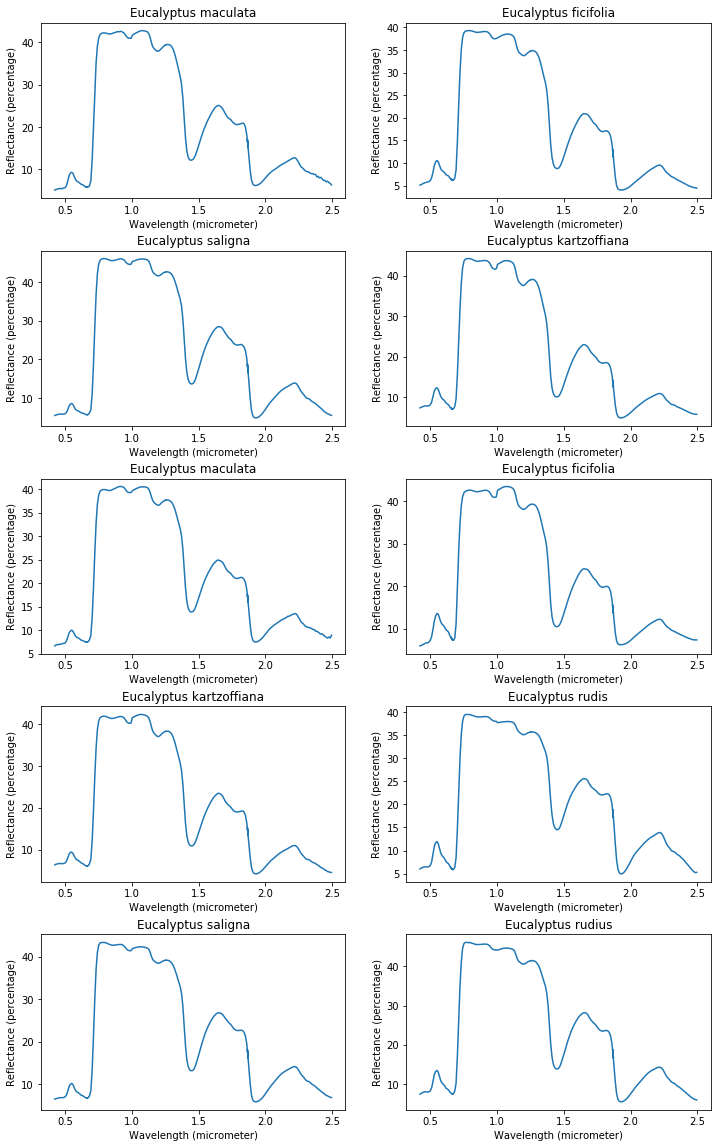

In [24]:
fig, axes = plt.subplots(5,2,figsize=(12,20))
for i in range(10):
    eucalib.spectra[i].plot(ax=axes[int(i/2), i%2])
plt.subplots_adjust(hspace=0.3)